# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

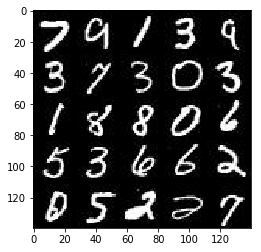

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

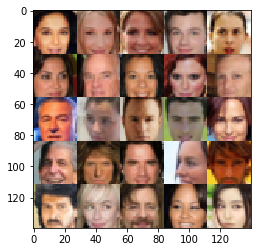

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [74]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # input = 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        #input = 14 x 14 x 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        #flatten 
        flat =  tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [75]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2

        # fully-connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # reshape
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        
        # 14x14x128 now
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [76]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [77]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [78]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [79]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    # Define Model_Inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Define Model_Loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Define Model_Opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    ### Training
    n_total_batches = data_shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            batch_counter = 0
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_counter += 1
                
                # Need to first scale real image values from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images*2.0
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                              input_z: batch_z,
                                              lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                # For each 10 batches, get the losses and print them out
                
                if batch_counter % 10 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} - Batch {}/{}: ".format(e+1, epoch_count, batch_counter, n_total_batches),
                         "Discriminator loss = {:.4f} ".format(d_train_loss),
                         "Generator loss = {:.4f}".format(g_train_loss))
                    
                # Show generator output samples so we can see the progress during training
                
                if batch_counter % 100 == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Batch 10/600:  Discriminator loss = 0.5760  Generator loss = 1.8010
Epoch 1/2 - Batch 20/600:  Discriminator loss = 1.5850  Generator loss = 0.4267
Epoch 1/2 - Batch 30/600:  Discriminator loss = 1.4933  Generator loss = 5.2318
Epoch 1/2 - Batch 40/600:  Discriminator loss = 1.1541  Generator loss = 0.7978
Epoch 1/2 - Batch 50/600:  Discriminator loss = 0.5779  Generator loss = 2.9763
Epoch 1/2 - Batch 60/600:  Discriminator loss = 0.7918  Generator loss = 2.0619
Epoch 1/2 - Batch 70/600:  Discriminator loss = 1.4307  Generator loss = 0.5044
Epoch 1/2 - Batch 80/600:  Discriminator loss = 0.6902  Generator loss = 1.5202
Epoch 1/2 - Batch 90/600:  Discriminator loss = 1.0335  Generator loss = 0.8412
Epoch 1/2 - Batch 100/600:  Discriminator loss = 0.7894  Generator loss = 1.8504


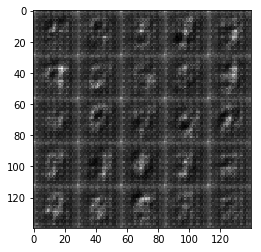

Epoch 1/2 - Batch 110/600:  Discriminator loss = 0.8343  Generator loss = 2.4264
Epoch 1/2 - Batch 120/600:  Discriminator loss = 0.8346  Generator loss = 1.2334
Epoch 1/2 - Batch 130/600:  Discriminator loss = 1.0187  Generator loss = 0.9887
Epoch 1/2 - Batch 140/600:  Discriminator loss = 0.7582  Generator loss = 2.3341
Epoch 1/2 - Batch 150/600:  Discriminator loss = 0.7917  Generator loss = 1.2973
Epoch 1/2 - Batch 160/600:  Discriminator loss = 0.7005  Generator loss = 1.5469
Epoch 1/2 - Batch 170/600:  Discriminator loss = 0.6949  Generator loss = 1.6249
Epoch 1/2 - Batch 180/600:  Discriminator loss = 1.3145  Generator loss = 3.6649
Epoch 1/2 - Batch 190/600:  Discriminator loss = 0.6868  Generator loss = 1.5896
Epoch 1/2 - Batch 200/600:  Discriminator loss = 0.6822  Generator loss = 1.5969


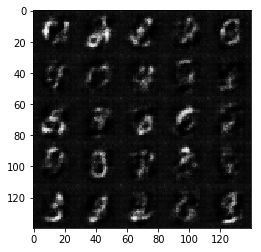

Epoch 1/2 - Batch 210/600:  Discriminator loss = 0.8274  Generator loss = 1.0872
Epoch 1/2 - Batch 220/600:  Discriminator loss = 1.0173  Generator loss = 3.5511
Epoch 1/2 - Batch 230/600:  Discriminator loss = 0.6144  Generator loss = 1.9650
Epoch 1/2 - Batch 240/600:  Discriminator loss = 0.5831  Generator loss = 2.4863
Epoch 1/2 - Batch 250/600:  Discriminator loss = 0.6705  Generator loss = 1.4168
Epoch 1/2 - Batch 260/600:  Discriminator loss = 0.5843  Generator loss = 1.7685
Epoch 1/2 - Batch 270/600:  Discriminator loss = 0.6116  Generator loss = 1.9649
Epoch 1/2 - Batch 280/600:  Discriminator loss = 0.8038  Generator loss = 1.1098
Epoch 1/2 - Batch 290/600:  Discriminator loss = 0.5883  Generator loss = 1.7234
Epoch 1/2 - Batch 300/600:  Discriminator loss = 0.6377  Generator loss = 2.2776


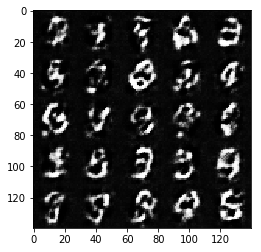

Epoch 1/2 - Batch 310/600:  Discriminator loss = 0.7209  Generator loss = 1.3086
Epoch 1/2 - Batch 320/600:  Discriminator loss = 0.5692  Generator loss = 1.9704
Epoch 1/2 - Batch 330/600:  Discriminator loss = 0.7129  Generator loss = 1.3582
Epoch 1/2 - Batch 340/600:  Discriminator loss = 0.8291  Generator loss = 1.0752
Epoch 1/2 - Batch 350/600:  Discriminator loss = 0.6479  Generator loss = 1.5584
Epoch 1/2 - Batch 360/600:  Discriminator loss = 0.5296  Generator loss = 2.2860
Epoch 1/2 - Batch 370/600:  Discriminator loss = 0.5860  Generator loss = 1.7249
Epoch 1/2 - Batch 380/600:  Discriminator loss = 1.0639  Generator loss = 3.7248
Epoch 1/2 - Batch 390/600:  Discriminator loss = 0.6982  Generator loss = 1.4181
Epoch 1/2 - Batch 400/600:  Discriminator loss = 0.6841  Generator loss = 1.4191


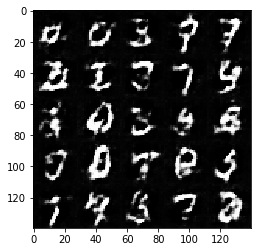

Epoch 1/2 - Batch 410/600:  Discriminator loss = 0.6701  Generator loss = 1.4497
Epoch 1/2 - Batch 420/600:  Discriminator loss = 0.5709  Generator loss = 2.0152
Epoch 1/2 - Batch 430/600:  Discriminator loss = 1.5626  Generator loss = 0.5626
Epoch 1/2 - Batch 440/600:  Discriminator loss = 0.7297  Generator loss = 1.3287
Epoch 1/2 - Batch 450/600:  Discriminator loss = 0.6144  Generator loss = 1.8973
Epoch 1/2 - Batch 460/600:  Discriminator loss = 0.6095  Generator loss = 2.3151
Epoch 1/2 - Batch 470/600:  Discriminator loss = 0.5845  Generator loss = 2.0420
Epoch 1/2 - Batch 480/600:  Discriminator loss = 0.5807  Generator loss = 2.2522
Epoch 1/2 - Batch 490/600:  Discriminator loss = 0.7473  Generator loss = 2.6026
Epoch 1/2 - Batch 500/600:  Discriminator loss = 0.5638  Generator loss = 2.1501


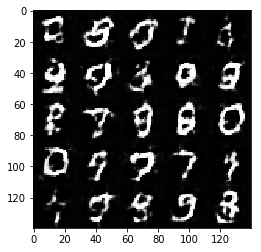

Epoch 1/2 - Batch 510/600:  Discriminator loss = 1.6150  Generator loss = 0.4408
Epoch 1/2 - Batch 520/600:  Discriminator loss = 0.7252  Generator loss = 1.4478
Epoch 1/2 - Batch 530/600:  Discriminator loss = 0.6813  Generator loss = 1.5059
Epoch 1/2 - Batch 540/600:  Discriminator loss = 0.7369  Generator loss = 1.2936
Epoch 1/2 - Batch 550/600:  Discriminator loss = 0.6803  Generator loss = 2.4617
Epoch 1/2 - Batch 560/600:  Discriminator loss = 1.2250  Generator loss = 0.6226
Epoch 1/2 - Batch 570/600:  Discriminator loss = 0.8432  Generator loss = 1.3684
Epoch 1/2 - Batch 580/600:  Discriminator loss = 0.7064  Generator loss = 1.8022
Epoch 1/2 - Batch 590/600:  Discriminator loss = 0.6853  Generator loss = 1.4454
Epoch 1/2 - Batch 600/600:  Discriminator loss = 0.9659  Generator loss = 0.9134


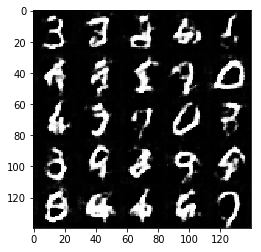

Epoch 2/2 - Batch 10/600:  Discriminator loss = 1.5340  Generator loss = 3.7215
Epoch 2/2 - Batch 20/600:  Discriminator loss = 1.1770  Generator loss = 0.7152
Epoch 2/2 - Batch 30/600:  Discriminator loss = 0.7444  Generator loss = 1.5021
Epoch 2/2 - Batch 40/600:  Discriminator loss = 0.6866  Generator loss = 1.8930
Epoch 2/2 - Batch 50/600:  Discriminator loss = 2.3180  Generator loss = 4.9842
Epoch 2/2 - Batch 60/600:  Discriminator loss = 0.6992  Generator loss = 1.4488
Epoch 2/2 - Batch 70/600:  Discriminator loss = 0.6420  Generator loss = 1.6795
Epoch 2/2 - Batch 80/600:  Discriminator loss = 0.7555  Generator loss = 1.2254
Epoch 2/2 - Batch 90/600:  Discriminator loss = 0.6146  Generator loss = 1.9200
Epoch 2/2 - Batch 100/600:  Discriminator loss = 0.6814  Generator loss = 1.4556


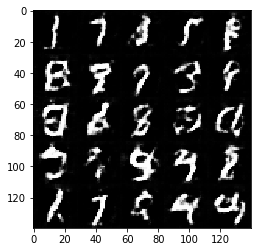

Epoch 2/2 - Batch 110/600:  Discriminator loss = 1.0435  Generator loss = 0.7706
Epoch 2/2 - Batch 120/600:  Discriminator loss = 0.7740  Generator loss = 1.6108
Epoch 2/2 - Batch 130/600:  Discriminator loss = 0.6376  Generator loss = 1.9358
Epoch 2/2 - Batch 140/600:  Discriminator loss = 0.7189  Generator loss = 1.4049
Epoch 2/2 - Batch 150/600:  Discriminator loss = 0.7103  Generator loss = 1.3195
Epoch 2/2 - Batch 160/600:  Discriminator loss = 0.7647  Generator loss = 1.1475
Epoch 2/2 - Batch 170/600:  Discriminator loss = 0.6987  Generator loss = 1.3519
Epoch 2/2 - Batch 180/600:  Discriminator loss = 0.6026  Generator loss = 2.1176
Epoch 2/2 - Batch 190/600:  Discriminator loss = 2.9134  Generator loss = 0.1490
Epoch 2/2 - Batch 200/600:  Discriminator loss = 1.0432  Generator loss = 1.0196


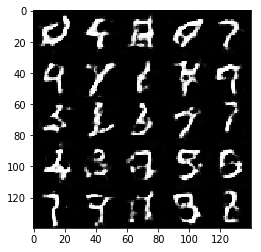

Epoch 2/2 - Batch 210/600:  Discriminator loss = 0.9308  Generator loss = 0.9914
Epoch 2/2 - Batch 220/600:  Discriminator loss = 0.8021  Generator loss = 1.6666
Epoch 2/2 - Batch 230/600:  Discriminator loss = 0.6961  Generator loss = 1.7029
Epoch 2/2 - Batch 240/600:  Discriminator loss = 0.6402  Generator loss = 1.5722
Epoch 2/2 - Batch 250/600:  Discriminator loss = 0.6883  Generator loss = 1.4033
Epoch 2/2 - Batch 260/600:  Discriminator loss = 0.7392  Generator loss = 1.2452
Epoch 2/2 - Batch 270/600:  Discriminator loss = 0.6686  Generator loss = 1.4414
Epoch 2/2 - Batch 280/600:  Discriminator loss = 0.7663  Generator loss = 1.2118
Epoch 2/2 - Batch 290/600:  Discriminator loss = 1.2794  Generator loss = 0.6772
Epoch 2/2 - Batch 300/600:  Discriminator loss = 1.0303  Generator loss = 0.9290


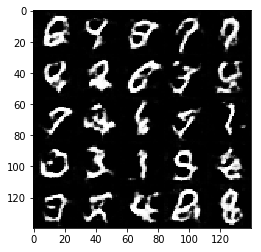

Epoch 2/2 - Batch 310/600:  Discriminator loss = 0.9560  Generator loss = 1.0055
Epoch 2/2 - Batch 320/600:  Discriminator loss = 1.0541  Generator loss = 0.8323
Epoch 2/2 - Batch 330/600:  Discriminator loss = 0.9730  Generator loss = 1.0041
Epoch 2/2 - Batch 340/600:  Discriminator loss = 0.8013  Generator loss = 1.2098
Epoch 2/2 - Batch 350/600:  Discriminator loss = 0.7687  Generator loss = 2.5838
Epoch 2/2 - Batch 360/600:  Discriminator loss = 0.6274  Generator loss = 1.9581
Epoch 2/2 - Batch 370/600:  Discriminator loss = 0.6601  Generator loss = 1.5392
Epoch 2/2 - Batch 380/600:  Discriminator loss = 1.1229  Generator loss = 0.7131
Epoch 2/2 - Batch 390/600:  Discriminator loss = 0.8584  Generator loss = 1.0811
Epoch 2/2 - Batch 400/600:  Discriminator loss = 0.7571  Generator loss = 1.2468


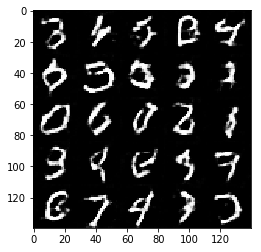

Epoch 2/2 - Batch 410/600:  Discriminator loss = 0.6795  Generator loss = 1.4365
Epoch 2/2 - Batch 420/600:  Discriminator loss = 0.6362  Generator loss = 1.7144
Epoch 2/2 - Batch 430/600:  Discriminator loss = 0.7621  Generator loss = 1.1957
Epoch 2/2 - Batch 440/600:  Discriminator loss = 0.9328  Generator loss = 0.9049
Epoch 2/2 - Batch 450/600:  Discriminator loss = 1.3358  Generator loss = 0.6123
Epoch 2/2 - Batch 460/600:  Discriminator loss = 1.2949  Generator loss = 2.4632
Epoch 2/2 - Batch 470/600:  Discriminator loss = 1.0482  Generator loss = 1.0744
Epoch 2/2 - Batch 480/600:  Discriminator loss = 1.1155  Generator loss = 0.7887
Epoch 2/2 - Batch 490/600:  Discriminator loss = 0.9403  Generator loss = 1.6486
Epoch 2/2 - Batch 500/600:  Discriminator loss = 0.8586  Generator loss = 2.1245


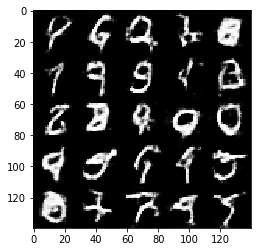

Epoch 2/2 - Batch 510/600:  Discriminator loss = 0.9559  Generator loss = 0.9376
Epoch 2/2 - Batch 520/600:  Discriminator loss = 1.1394  Generator loss = 0.7240
Epoch 2/2 - Batch 530/600:  Discriminator loss = 1.3500  Generator loss = 0.5584
Epoch 2/2 - Batch 540/600:  Discriminator loss = 0.7525  Generator loss = 1.8696
Epoch 2/2 - Batch 550/600:  Discriminator loss = 1.2276  Generator loss = 0.6600
Epoch 2/2 - Batch 560/600:  Discriminator loss = 1.1091  Generator loss = 0.7406
Epoch 2/2 - Batch 570/600:  Discriminator loss = 0.8605  Generator loss = 1.1117
Epoch 2/2 - Batch 580/600:  Discriminator loss = 0.6467  Generator loss = 2.0093
Epoch 2/2 - Batch 590/600:  Discriminator loss = 0.6973  Generator loss = 1.4674
Epoch 2/2 - Batch 600/600:  Discriminator loss = 0.7888  Generator loss = 1.1894


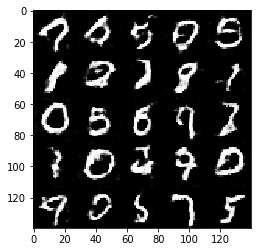

In [80]:
batch_size = 100
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/2025:  Discriminator loss = 0.5595  Generator loss = 2.3367
Epoch 1/1 - Batch 20/2025:  Discriminator loss = 0.7501  Generator loss = 1.4985
Epoch 1/1 - Batch 30/2025:  Discriminator loss = 0.4723  Generator loss = 6.1548
Epoch 1/1 - Batch 40/2025:  Discriminator loss = 0.7848  Generator loss = 10.6601
Epoch 1/1 - Batch 50/2025:  Discriminator loss = 0.7524  Generator loss = 1.9767
Epoch 1/1 - Batch 60/2025:  Discriminator loss = 1.2670  Generator loss = 0.8885
Epoch 1/1 - Batch 70/2025:  Discriminator loss = 1.2022  Generator loss = 0.7062
Epoch 1/1 - Batch 80/2025:  Discriminator loss = 0.7281  Generator loss = 2.4627
Epoch 1/1 - Batch 90/2025:  Discriminator loss = 0.9878  Generator loss = 0.9837
Epoch 1/1 - Batch 100/2025:  Discriminator loss = 0.6872  Generator loss = 3.3327


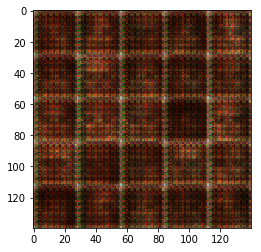

Epoch 1/1 - Batch 110/2025:  Discriminator loss = 0.6571  Generator loss = 2.0575
Epoch 1/1 - Batch 120/2025:  Discriminator loss = 0.6372  Generator loss = 2.3607
Epoch 1/1 - Batch 130/2025:  Discriminator loss = 0.6910  Generator loss = 2.8790
Epoch 1/1 - Batch 140/2025:  Discriminator loss = 1.1238  Generator loss = 0.8197
Epoch 1/1 - Batch 150/2025:  Discriminator loss = 0.8767  Generator loss = 1.1768
Epoch 1/1 - Batch 160/2025:  Discriminator loss = 0.6091  Generator loss = 1.9298
Epoch 1/1 - Batch 170/2025:  Discriminator loss = 0.6913  Generator loss = 1.7616
Epoch 1/1 - Batch 180/2025:  Discriminator loss = 0.9583  Generator loss = 2.8273
Epoch 1/1 - Batch 190/2025:  Discriminator loss = 1.0454  Generator loss = 3.4050
Epoch 1/1 - Batch 200/2025:  Discriminator loss = 0.8082  Generator loss = 1.3395


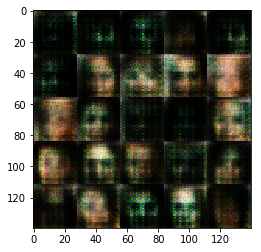

Epoch 1/1 - Batch 210/2025:  Discriminator loss = 0.9437  Generator loss = 1.2152
Epoch 1/1 - Batch 220/2025:  Discriminator loss = 0.9322  Generator loss = 1.1178
Epoch 1/1 - Batch 230/2025:  Discriminator loss = 1.1241  Generator loss = 0.8496
Epoch 1/1 - Batch 240/2025:  Discriminator loss = 0.7887  Generator loss = 1.5951
Epoch 1/1 - Batch 250/2025:  Discriminator loss = 1.0264  Generator loss = 1.4367
Epoch 1/1 - Batch 260/2025:  Discriminator loss = 0.9324  Generator loss = 1.0812
Epoch 1/1 - Batch 270/2025:  Discriminator loss = 0.9476  Generator loss = 1.0986
Epoch 1/1 - Batch 280/2025:  Discriminator loss = 0.9376  Generator loss = 1.0891
Epoch 1/1 - Batch 290/2025:  Discriminator loss = 0.7881  Generator loss = 1.7054
Epoch 1/1 - Batch 300/2025:  Discriminator loss = 1.3707  Generator loss = 0.5476


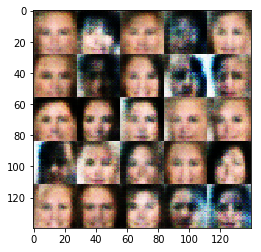

Epoch 1/1 - Batch 310/2025:  Discriminator loss = 0.9761  Generator loss = 1.2565
Epoch 1/1 - Batch 320/2025:  Discriminator loss = 0.7782  Generator loss = 1.3800
Epoch 1/1 - Batch 330/2025:  Discriminator loss = 0.9958  Generator loss = 1.6664
Epoch 1/1 - Batch 340/2025:  Discriminator loss = 1.1527  Generator loss = 0.7904
Epoch 1/1 - Batch 350/2025:  Discriminator loss = 1.1356  Generator loss = 0.9173
Epoch 1/1 - Batch 360/2025:  Discriminator loss = 0.8994  Generator loss = 1.4797
Epoch 1/1 - Batch 370/2025:  Discriminator loss = 1.1194  Generator loss = 0.9492
Epoch 1/1 - Batch 380/2025:  Discriminator loss = 0.7243  Generator loss = 1.7878
Epoch 1/1 - Batch 390/2025:  Discriminator loss = 0.9052  Generator loss = 1.5714
Epoch 1/1 - Batch 400/2025:  Discriminator loss = 0.9321  Generator loss = 1.7738


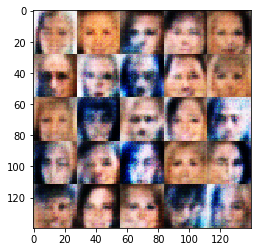

Epoch 1/1 - Batch 410/2025:  Discriminator loss = 1.1480  Generator loss = 0.9331
Epoch 1/1 - Batch 420/2025:  Discriminator loss = 0.8889  Generator loss = 1.4773
Epoch 1/1 - Batch 430/2025:  Discriminator loss = 0.8506  Generator loss = 1.2664
Epoch 1/1 - Batch 440/2025:  Discriminator loss = 0.9286  Generator loss = 1.0656
Epoch 1/1 - Batch 450/2025:  Discriminator loss = 1.0904  Generator loss = 1.3845
Epoch 1/1 - Batch 460/2025:  Discriminator loss = 1.1034  Generator loss = 1.5681
Epoch 1/1 - Batch 470/2025:  Discriminator loss = 1.1774  Generator loss = 0.7962
Epoch 1/1 - Batch 480/2025:  Discriminator loss = 1.0991  Generator loss = 0.8743
Epoch 1/1 - Batch 490/2025:  Discriminator loss = 1.0050  Generator loss = 1.0535
Epoch 1/1 - Batch 500/2025:  Discriminator loss = 0.9639  Generator loss = 1.2344


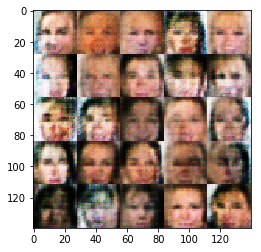

Epoch 1/1 - Batch 510/2025:  Discriminator loss = 1.1273  Generator loss = 0.9452
Epoch 1/1 - Batch 520/2025:  Discriminator loss = 1.2278  Generator loss = 1.9350
Epoch 1/1 - Batch 530/2025:  Discriminator loss = 0.9967  Generator loss = 1.3337
Epoch 1/1 - Batch 540/2025:  Discriminator loss = 1.3604  Generator loss = 0.5704
Epoch 1/1 - Batch 550/2025:  Discriminator loss = 1.0759  Generator loss = 1.9823
Epoch 1/1 - Batch 560/2025:  Discriminator loss = 1.0476  Generator loss = 1.9653
Epoch 1/1 - Batch 570/2025:  Discriminator loss = 1.2281  Generator loss = 2.1219
Epoch 1/1 - Batch 580/2025:  Discriminator loss = 1.0894  Generator loss = 1.4666
Epoch 1/1 - Batch 590/2025:  Discriminator loss = 1.2114  Generator loss = 0.8157
Epoch 1/1 - Batch 600/2025:  Discriminator loss = 1.2764  Generator loss = 0.6250


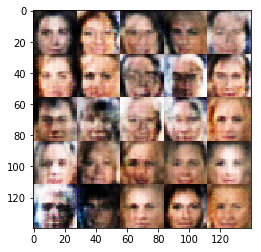

Epoch 1/1 - Batch 610/2025:  Discriminator loss = 1.0978  Generator loss = 1.3667
Epoch 1/1 - Batch 620/2025:  Discriminator loss = 1.3199  Generator loss = 0.5948
Epoch 1/1 - Batch 630/2025:  Discriminator loss = 1.2612  Generator loss = 0.7071
Epoch 1/1 - Batch 640/2025:  Discriminator loss = 0.9940  Generator loss = 1.5634
Epoch 1/1 - Batch 650/2025:  Discriminator loss = 0.8853  Generator loss = 1.4960
Epoch 1/1 - Batch 660/2025:  Discriminator loss = 1.1012  Generator loss = 2.2414
Epoch 1/1 - Batch 670/2025:  Discriminator loss = 1.0492  Generator loss = 1.0081
Epoch 1/1 - Batch 680/2025:  Discriminator loss = 1.0929  Generator loss = 1.3846
Epoch 1/1 - Batch 690/2025:  Discriminator loss = 1.0942  Generator loss = 0.9236
Epoch 1/1 - Batch 700/2025:  Discriminator loss = 1.5022  Generator loss = 0.4682


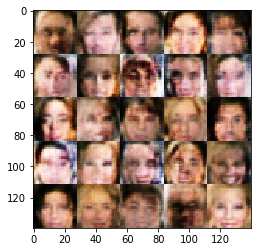

Epoch 1/1 - Batch 710/2025:  Discriminator loss = 1.0174  Generator loss = 0.8953
Epoch 1/1 - Batch 720/2025:  Discriminator loss = 1.0576  Generator loss = 1.6826
Epoch 1/1 - Batch 730/2025:  Discriminator loss = 0.9843  Generator loss = 1.1297
Epoch 1/1 - Batch 740/2025:  Discriminator loss = 1.0689  Generator loss = 1.1383
Epoch 1/1 - Batch 750/2025:  Discriminator loss = 0.9266  Generator loss = 1.5654
Epoch 1/1 - Batch 760/2025:  Discriminator loss = 1.2316  Generator loss = 2.4946
Epoch 1/1 - Batch 770/2025:  Discriminator loss = 0.9764  Generator loss = 1.2557
Epoch 1/1 - Batch 780/2025:  Discriminator loss = 1.1029  Generator loss = 1.0416
Epoch 1/1 - Batch 790/2025:  Discriminator loss = 1.1271  Generator loss = 1.2136
Epoch 1/1 - Batch 800/2025:  Discriminator loss = 1.0322  Generator loss = 1.0857


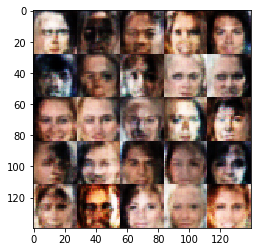

Epoch 1/1 - Batch 810/2025:  Discriminator loss = 1.0514  Generator loss = 1.2255
Epoch 1/1 - Batch 820/2025:  Discriminator loss = 1.2403  Generator loss = 2.5344
Epoch 1/1 - Batch 830/2025:  Discriminator loss = 1.0330  Generator loss = 0.9997
Epoch 1/1 - Batch 840/2025:  Discriminator loss = 1.0438  Generator loss = 2.0548
Epoch 1/1 - Batch 850/2025:  Discriminator loss = 1.0116  Generator loss = 1.3737
Epoch 1/1 - Batch 860/2025:  Discriminator loss = 1.2177  Generator loss = 0.6740
Epoch 1/1 - Batch 870/2025:  Discriminator loss = 1.0723  Generator loss = 0.8955
Epoch 1/1 - Batch 880/2025:  Discriminator loss = 0.9638  Generator loss = 1.3229
Epoch 1/1 - Batch 890/2025:  Discriminator loss = 1.5729  Generator loss = 2.8420
Epoch 1/1 - Batch 900/2025:  Discriminator loss = 0.9898  Generator loss = 1.4243


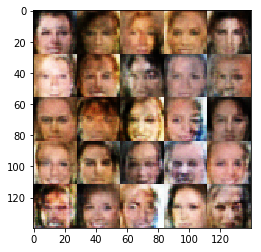

Epoch 1/1 - Batch 910/2025:  Discriminator loss = 1.0236  Generator loss = 1.6135
Epoch 1/1 - Batch 920/2025:  Discriminator loss = 1.2832  Generator loss = 0.6053
Epoch 1/1 - Batch 930/2025:  Discriminator loss = 1.0103  Generator loss = 1.0039
Epoch 1/1 - Batch 940/2025:  Discriminator loss = 0.9485  Generator loss = 1.5250
Epoch 1/1 - Batch 950/2025:  Discriminator loss = 1.1187  Generator loss = 2.0448
Epoch 1/1 - Batch 960/2025:  Discriminator loss = 0.9529  Generator loss = 1.8419
Epoch 1/1 - Batch 970/2025:  Discriminator loss = 0.8951  Generator loss = 1.1287
Epoch 1/1 - Batch 980/2025:  Discriminator loss = 1.2246  Generator loss = 0.7373
Epoch 1/1 - Batch 990/2025:  Discriminator loss = 1.0430  Generator loss = 0.9194
Epoch 1/1 - Batch 1000/2025:  Discriminator loss = 1.3380  Generator loss = 2.4327


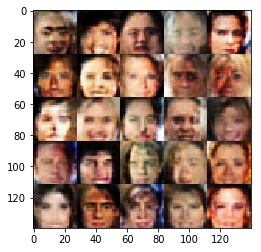

Epoch 1/1 - Batch 1010/2025:  Discriminator loss = 1.0260  Generator loss = 0.8624
Epoch 1/1 - Batch 1020/2025:  Discriminator loss = 1.4354  Generator loss = 2.3601
Epoch 1/1 - Batch 1030/2025:  Discriminator loss = 0.9622  Generator loss = 1.0725
Epoch 1/1 - Batch 1040/2025:  Discriminator loss = 1.4655  Generator loss = 0.4772
Epoch 1/1 - Batch 1050/2025:  Discriminator loss = 0.9818  Generator loss = 1.4151
Epoch 1/1 - Batch 1060/2025:  Discriminator loss = 1.0345  Generator loss = 0.9634
Epoch 1/1 - Batch 1070/2025:  Discriminator loss = 1.2417  Generator loss = 0.6327
Epoch 1/1 - Batch 1080/2025:  Discriminator loss = 0.8883  Generator loss = 1.7477
Epoch 1/1 - Batch 1090/2025:  Discriminator loss = 0.9157  Generator loss = 1.4949
Epoch 1/1 - Batch 1100/2025:  Discriminator loss = 1.0172  Generator loss = 1.2752


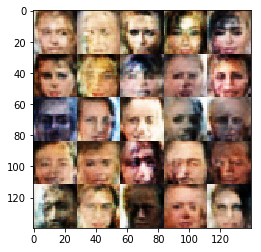

Epoch 1/1 - Batch 1110/2025:  Discriminator loss = 0.9911  Generator loss = 1.8710
Epoch 1/1 - Batch 1120/2025:  Discriminator loss = 1.0609  Generator loss = 2.1164
Epoch 1/1 - Batch 1130/2025:  Discriminator loss = 0.9313  Generator loss = 1.6180
Epoch 1/1 - Batch 1140/2025:  Discriminator loss = 0.9371  Generator loss = 1.3452
Epoch 1/1 - Batch 1150/2025:  Discriminator loss = 2.1316  Generator loss = 0.2472
Epoch 1/1 - Batch 1160/2025:  Discriminator loss = 1.1365  Generator loss = 1.6820
Epoch 1/1 - Batch 1170/2025:  Discriminator loss = 0.8465  Generator loss = 1.3872
Epoch 1/1 - Batch 1180/2025:  Discriminator loss = 1.1006  Generator loss = 2.3442
Epoch 1/1 - Batch 1190/2025:  Discriminator loss = 1.2160  Generator loss = 0.6680
Epoch 1/1 - Batch 1200/2025:  Discriminator loss = 1.2518  Generator loss = 2.5260


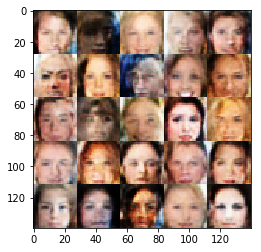

Epoch 1/1 - Batch 1210/2025:  Discriminator loss = 0.9745  Generator loss = 1.1320
Epoch 1/1 - Batch 1220/2025:  Discriminator loss = 1.0531  Generator loss = 0.8209
Epoch 1/1 - Batch 1230/2025:  Discriminator loss = 1.0285  Generator loss = 0.9024
Epoch 1/1 - Batch 1240/2025:  Discriminator loss = 0.9408  Generator loss = 1.2777
Epoch 1/1 - Batch 1250/2025:  Discriminator loss = 0.7551  Generator loss = 1.5840
Epoch 1/1 - Batch 1260/2025:  Discriminator loss = 0.9338  Generator loss = 1.4151
Epoch 1/1 - Batch 1270/2025:  Discriminator loss = 1.0063  Generator loss = 0.9280
Epoch 1/1 - Batch 1280/2025:  Discriminator loss = 1.1116  Generator loss = 0.7568
Epoch 1/1 - Batch 1290/2025:  Discriminator loss = 1.3021  Generator loss = 0.5877
Epoch 1/1 - Batch 1300/2025:  Discriminator loss = 0.9506  Generator loss = 1.5748


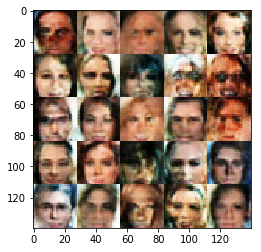

Epoch 1/1 - Batch 1310/2025:  Discriminator loss = 0.9164  Generator loss = 1.2999
Epoch 1/1 - Batch 1320/2025:  Discriminator loss = 0.8806  Generator loss = 1.2670
Epoch 1/1 - Batch 1330/2025:  Discriminator loss = 1.0250  Generator loss = 1.3172
Epoch 1/1 - Batch 1340/2025:  Discriminator loss = 0.9854  Generator loss = 1.3096
Epoch 1/1 - Batch 1350/2025:  Discriminator loss = 1.1288  Generator loss = 0.7323
Epoch 1/1 - Batch 1360/2025:  Discriminator loss = 1.1017  Generator loss = 1.7738
Epoch 1/1 - Batch 1370/2025:  Discriminator loss = 1.1714  Generator loss = 0.7402
Epoch 1/1 - Batch 1380/2025:  Discriminator loss = 0.8095  Generator loss = 1.6397
Epoch 1/1 - Batch 1390/2025:  Discriminator loss = 1.0096  Generator loss = 1.1961
Epoch 1/1 - Batch 1400/2025:  Discriminator loss = 0.8269  Generator loss = 1.4213


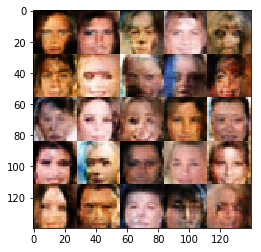

Epoch 1/1 - Batch 1410/2025:  Discriminator loss = 0.8901  Generator loss = 1.3693
Epoch 1/1 - Batch 1420/2025:  Discriminator loss = 0.8636  Generator loss = 1.3348
Epoch 1/1 - Batch 1430/2025:  Discriminator loss = 0.8907  Generator loss = 1.2545
Epoch 1/1 - Batch 1440/2025:  Discriminator loss = 1.3352  Generator loss = 0.5866
Epoch 1/1 - Batch 1450/2025:  Discriminator loss = 0.9243  Generator loss = 0.9437
Epoch 1/1 - Batch 1460/2025:  Discriminator loss = 0.8353  Generator loss = 1.0856
Epoch 1/1 - Batch 1470/2025:  Discriminator loss = 1.1908  Generator loss = 0.6973
Epoch 1/1 - Batch 1480/2025:  Discriminator loss = 2.0651  Generator loss = 0.2756
Epoch 1/1 - Batch 1490/2025:  Discriminator loss = 0.9456  Generator loss = 1.1514
Epoch 1/1 - Batch 1500/2025:  Discriminator loss = 1.0409  Generator loss = 0.9733


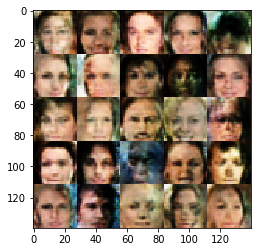

Epoch 1/1 - Batch 1510/2025:  Discriminator loss = 1.0106  Generator loss = 2.1575
Epoch 1/1 - Batch 1520/2025:  Discriminator loss = 0.9811  Generator loss = 0.9254
Epoch 1/1 - Batch 1530/2025:  Discriminator loss = 0.8175  Generator loss = 1.6490
Epoch 1/1 - Batch 1540/2025:  Discriminator loss = 0.7487  Generator loss = 1.2904
Epoch 1/1 - Batch 1550/2025:  Discriminator loss = 0.7986  Generator loss = 1.5141
Epoch 1/1 - Batch 1560/2025:  Discriminator loss = 1.0559  Generator loss = 0.8265
Epoch 1/1 - Batch 1570/2025:  Discriminator loss = 1.2881  Generator loss = 0.6204
Epoch 1/1 - Batch 1580/2025:  Discriminator loss = 0.6827  Generator loss = 1.5859
Epoch 1/1 - Batch 1590/2025:  Discriminator loss = 1.1741  Generator loss = 1.5498
Epoch 1/1 - Batch 1600/2025:  Discriminator loss = 0.8857  Generator loss = 1.1679


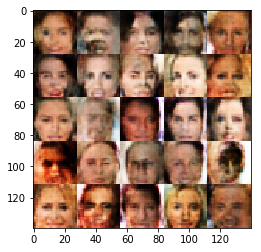

Epoch 1/1 - Batch 1610/2025:  Discriminator loss = 1.3748  Generator loss = 0.5326
Epoch 1/1 - Batch 1620/2025:  Discriminator loss = 0.8701  Generator loss = 1.8884
Epoch 1/1 - Batch 1630/2025:  Discriminator loss = 0.6161  Generator loss = 1.9208
Epoch 1/1 - Batch 1640/2025:  Discriminator loss = 0.7259  Generator loss = 2.2408
Epoch 1/1 - Batch 1650/2025:  Discriminator loss = 1.0101  Generator loss = 1.1462
Epoch 1/1 - Batch 1660/2025:  Discriminator loss = 1.2307  Generator loss = 0.6341
Epoch 1/1 - Batch 1670/2025:  Discriminator loss = 0.6989  Generator loss = 2.2237
Epoch 1/1 - Batch 1680/2025:  Discriminator loss = 0.8996  Generator loss = 0.9936
Epoch 1/1 - Batch 1690/2025:  Discriminator loss = 0.6871  Generator loss = 2.0845
Epoch 1/1 - Batch 1700/2025:  Discriminator loss = 0.7050  Generator loss = 1.9566


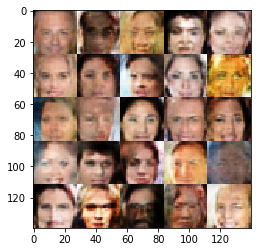

Epoch 1/1 - Batch 1710/2025:  Discriminator loss = 0.7396  Generator loss = 1.4689
Epoch 1/1 - Batch 1720/2025:  Discriminator loss = 1.1364  Generator loss = 1.7077
Epoch 1/1 - Batch 1730/2025:  Discriminator loss = 1.3060  Generator loss = 0.6237
Epoch 1/1 - Batch 1740/2025:  Discriminator loss = 1.2491  Generator loss = 2.3965
Epoch 1/1 - Batch 1750/2025:  Discriminator loss = 0.8714  Generator loss = 1.4977
Epoch 1/1 - Batch 1760/2025:  Discriminator loss = 1.1497  Generator loss = 0.7186
Epoch 1/1 - Batch 1770/2025:  Discriminator loss = 0.7339  Generator loss = 1.8774
Epoch 1/1 - Batch 1780/2025:  Discriminator loss = 0.9247  Generator loss = 1.1853
Epoch 1/1 - Batch 1790/2025:  Discriminator loss = 0.9124  Generator loss = 1.4917
Epoch 1/1 - Batch 1800/2025:  Discriminator loss = 1.6144  Generator loss = 2.3525


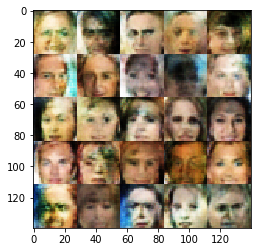

Epoch 1/1 - Batch 1810/2025:  Discriminator loss = 0.8899  Generator loss = 1.5496
Epoch 1/1 - Batch 1820/2025:  Discriminator loss = 0.8117  Generator loss = 1.6561
Epoch 1/1 - Batch 1830/2025:  Discriminator loss = 0.8886  Generator loss = 1.7703
Epoch 1/1 - Batch 1840/2025:  Discriminator loss = 1.1730  Generator loss = 0.6749
Epoch 1/1 - Batch 1850/2025:  Discriminator loss = 0.7893  Generator loss = 2.0313
Epoch 1/1 - Batch 1860/2025:  Discriminator loss = 0.8597  Generator loss = 1.1066
Epoch 1/1 - Batch 1870/2025:  Discriminator loss = 1.4318  Generator loss = 2.7442
Epoch 1/1 - Batch 1880/2025:  Discriminator loss = 1.0789  Generator loss = 2.0612
Epoch 1/1 - Batch 1890/2025:  Discriminator loss = 0.8838  Generator loss = 1.8718
Epoch 1/1 - Batch 1900/2025:  Discriminator loss = 0.7618  Generator loss = 1.3290


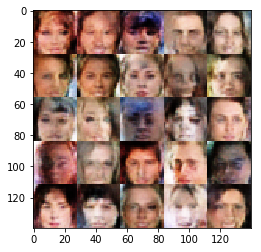

Epoch 1/1 - Batch 1910/2025:  Discriminator loss = 0.7502  Generator loss = 1.3841
Epoch 1/1 - Batch 1920/2025:  Discriminator loss = 0.7942  Generator loss = 1.3545
Epoch 1/1 - Batch 1930/2025:  Discriminator loss = 0.6445  Generator loss = 2.0207
Epoch 1/1 - Batch 1940/2025:  Discriminator loss = 0.7048  Generator loss = 2.8623
Epoch 1/1 - Batch 1950/2025:  Discriminator loss = 1.8601  Generator loss = 3.6291
Epoch 1/1 - Batch 1960/2025:  Discriminator loss = 1.0651  Generator loss = 1.9744
Epoch 1/1 - Batch 1970/2025:  Discriminator loss = 1.1833  Generator loss = 0.7241
Epoch 1/1 - Batch 1980/2025:  Discriminator loss = 0.6357  Generator loss = 2.1249
Epoch 1/1 - Batch 1990/2025:  Discriminator loss = 0.9553  Generator loss = 2.0977
Epoch 1/1 - Batch 2000/2025:  Discriminator loss = 0.6435  Generator loss = 1.7303


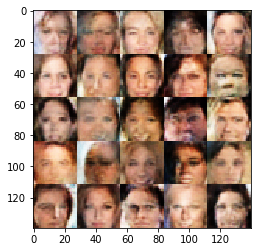

Epoch 1/1 - Batch 2010/2025:  Discriminator loss = 0.7049  Generator loss = 1.6596
Epoch 1/1 - Batch 2020/2025:  Discriminator loss = 0.6299  Generator loss = 1.9360


In [81]:
batch_size = 100
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
n_images = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.